# Used libraries

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
import statsmodels.api as sm
import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

## Loading data

The train and test inputs are composed of 46 features.

The target of this challenge is `RET` and corresponds to the fact that the **return is in the top 50% of highest stock returns**.

Since the median is very close to 0, this information should not change much with the idea to predict the sign of the return.

In [2]:
x_train = pd.read_csv('../x_train.csv', index_col='ID')
y_train = pd.read_csv('../y_train.csv', index_col='ID')
train = pd.concat([x_train, y_train], axis=1)
test = pd.read_csv('../x_test.csv', index_col='ID')
train.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.015748,0.147931,-0.015504,0.179183,...,0.630899,0.003254,-0.379412,0.008752,-0.110597,-0.012959,0.174521,-0.002155,-0.000937,True
1,0,3,43,15,6,104,0.003984,NaN,-0.090580,NaN,...,NaN,0.003774,NaN,-0.018518,NaN,-0.028777,NaN,-0.034722,NaN,True
2,0,4,57,20,8,142,0.000440,-0.096282,-0.058896,0.084771,...,-0.010336,-0.017612,-0.354333,-0.006562,-0.519391,-0.012101,-0.356157,-0.006867,-0.308868,False
3,0,8,1,1,1,2,0.031298,-0.429540,0.007756,-0.089919,...,0.012105,0.033824,-0.290178,-0.001468,-0.663834,-0.013520,-0.562126,-0.036745,-0.631458,False
4,0,14,36,12,5,92,0.027273,-0.847155,-0.039302,-0.943033,...,-0.277083,-0.012659,0.139086,0.004237,-0.017547,0.004256,0.579510,-0.040817,0.802806,False


In [3]:
ret=[f'RET_{k}' for k in range(20,0,-1)]
vol=[f'VOLUME_{k}' for k in range(20,0,-1)]

# Exploration des secteurs

Nombre de points par secteur :

In [4]:
nb_sec = len(train.SECTOR.unique())

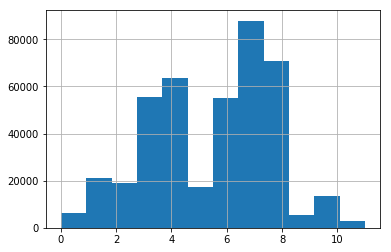

In [5]:
train.SECTOR.hist(bins=nb_sec)

In [6]:
train.groupby(by='SECTOR').count()['DATE']

SECTOR
0      6304
1     21264
2     18967
3     55473
4     63519
5     17295
6     55123
7     87903
8     70843
9      5555
10    13295
11     3054
Name: DATE, dtype: int64

# Cleaning : remplacement des NaN par les médianes par secteur

In [7]:
train_cl = train.copy()
test_cl = test.copy()
for sect in range(nb_sec):
    for ret_t,vol_t in zip(ret,vol):
        med_ret_train = train[ret_t][train['SECTOR']==sect].median()
        med_vol_train = train[vol_t][train['SECTOR']==sect].median()
        med_ret_test = train[ret_t][train['SECTOR']==sect].median()
        med_vol_test = train[vol_t][train['SECTOR']==sect].median()
        
        train_cl[ret_t] = train_cl[ret_t].fillna(med_ret_train)
        train_cl[vol_t] = train_cl[vol_t].fillna(med_vol_train)
        test_cl[ret_t] = test_cl[ret_t].fillna(med_ret_test)
        test_cl[vol_t] = test_cl[vol_t].fillna(med_vol_test)

# Scaling

In [8]:
scaler = StandardScaler()

In [9]:
train_cl[ret+vol] = scaler.fit_transform(train_cl[ret+vol])
test_cl[ret+vol] = scaler.fit_transform(test_cl[ret+vol])
train_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20,RET
ID,,,,,,,,,,,,,,,,,,,,,
0,0,2,18,5,3,44,-0.548411,0.090205,-0.533128,0.118373,...,0.369549,0.051337,-0.135215,0.244455,0.000153,-0.398164,0.138928,-0.064255,0.044563,True
1,0,3,43,15,6,104,0.083572,-0.063399,-2.963086,-0.069950,...,-0.087656,0.067729,-0.089013,-0.628631,-0.081377,-0.916076,-0.084071,-1.047144,-0.073966,True
2,0,4,57,20,8,142,-0.029924,0.002790,-1.937575,0.079337,...,0.049558,-0.606663,-0.122245,-0.245831,-0.183962,-0.370059,-0.120714,-0.206441,-0.078988,False
3,0,8,1,1,1,2,0.958389,-0.116499,0.219699,0.007111,...,0.060757,1.015334,-0.089066,-0.082767,-0.249018,-0.416536,-0.221488,-1.108181,-0.208420,False
4,0,14,36,12,5,92,0.829460,-0.265982,-1.303374,-0.345611,...,-0.083555,-0.450444,0.132934,0.099901,0.042062,0.165460,0.337076,-1.231082,0.367047,False


In [10]:
test_cl.head()

,DATE,STOCK,INDUSTRY,INDUSTRY_GROUP,SECTOR,SUB_INDUSTRY,RET_1,VOLUME_1,RET_2,VOLUME_2,...,RET_16,VOLUME_16,RET_17,VOLUME_17,RET_18,VOLUME_18,RET_19,VOLUME_19,RET_20,VOLUME_20
ID,,,,,,,,,,,,,,,,,,,,,
418595,2,0,37,12,5,94,0.659985,0.055211,0.275432,0.054565,...,0.663303,-0.031916,-0.077006,-0.079964,0.023467,0.050283,0.008503,-0.006802,0.644021,0.027280
418596,2,1,15,4,3,37,0.290723,-0.028828,0.664285,-0.097103,...,-0.154947,-0.149778,-0.093803,-0.077944,0.080711,0.194547,-0.236004,-0.080440,0.159131,-0.095930
418597,2,4,57,20,8,142,0.153153,-0.000143,0.139440,0.000810,...,0.063471,-0.078750,0.336667,-0.112172,0.350132,-0.080709,0.013170,0.043524,0.038106,-0.016210
418598,2,5,35,12,5,91,0.498682,0.005255,-0.505231,0.026038,...,-0.453828,0.049484,1.180694,0.209310,-0.076162,0.103012,-0.245979,-0.009691,0.267310,-0.047895
418599,2,6,57,20,8,142,0.366914,-0.036729,0.693621,-0.024313,...,-0.050853,-0.114292,0.099463,-0.103968,-0.865823,-0.049073,0.353061,0.137099,-0.250134,0.231649


# Sélection des features

## Features de base

In [11]:
nb_feat = 20 #nb de jours pris en compte
features_base = ret[-nb_feat:]+vol[-nb_feat:]
target = 'RET'

## New features

In [23]:
nb_shifts = 5 #nombre de features supplémentaires

new_features = []

# Conditional aggregated features
shifts = range(1,nb_shifts+1)  # Choose some different shifts
statistics = ['median']  # the type of stat
gb_features = ['SECTOR', 'DATE']
target_feature = 'RET'
tmp_name = '_'.join(gb_features)
for shift in shifts:
    for stat in statistics:
        name = f'{target_feature}_{shift}_{tmp_name}_{stat}'
        feat = f'{target_feature}_{shift}'
        new_features.append(name)
        for data in [train_cl,test_cl]:
            data[name] = data.groupby(gb_features)[feat].transform(stat)

In [24]:
features = features_base + new_features

In [14]:
features

['RET_20',
 'RET_19',
 'RET_18',
 'RET_17',
 'RET_16',
 'RET_15',
 'RET_14',
 'RET_13',
 'RET_12',
 'RET_11',
 'RET_10',
 'RET_9',
 'RET_8',
 'RET_7',
 'RET_6',
 'RET_5',
 'RET_4',
 'RET_3',
 'RET_2',
 'RET_1',
 'VOLUME_20',
 'VOLUME_19',
 'VOLUME_18',
 'VOLUME_17',
 'VOLUME_16',
 'VOLUME_15',
 'VOLUME_14',
 'VOLUME_13',
 'VOLUME_12',
 'VOLUME_11',
 'VOLUME_10',
 'VOLUME_9',
 'VOLUME_8',
 'VOLUME_7',
 'VOLUME_6',
 'VOLUME_5',
 'VOLUME_4',
 'VOLUME_3',
 'VOLUME_2',
 'VOLUME_1',
 'RET_1_SECTOR_DATE_median',
 'RET_2_SECTOR_DATE_median',
 'RET_3_SECTOR_DATE_median',
 'RET_4_SECTOR_DATE_median',
 'RET_5_SECTOR_DATE_median']

# Entraînement des modèles

In [15]:
models = []
for sect in range(nb_sec):
    x_train_cl = train_cl[features][train_cl['SECTOR']==sect]
    y_train_cl = train_cl[target][train_cl['SECTOR']==sect]
    
    rf_params = {
    'n_estimators': 500,
    'max_depth': 2**3,
    'random_state': 0,
    'n_jobs': -1
    }
    
    model = RandomForestClassifier(**rf_params)
    model.fit(x_train_cl, y_train_cl)
    models.append(model)

# Prédictions et précision locales

In [16]:
y_pred = pd.Series()
for sect in range(nb_sec):
    x_test = train_cl[train_cl['SECTOR']==sect].loc[:,features]
    index = x_test.index
    y_test = train_cl[train_cl['SECTOR']==sect].loc[:,target]
    model = models[sect]
    y_pred = pd.concat([y_pred,pd.Series(model.predict(x_test),index=x_test.index)])
    print(sect)
y_pred = y_pred.sort_index()

0
1
2
3
4
5
6
7
8
9
10
11


In [17]:
accuracy_score(train_cl[target], y_pred)

0.6648502729368483

# Prédictions sur test set

In [25]:
y_pred = pd.Series()
for sect in range(nb_sec):
    x_test = test_cl[test_cl['SECTOR']==sect].loc[:,features]
    index = x_test.index
    model = models[sect]
    y_pred = pd.concat([y_pred,pd.Series(model.predict(x_test),index=x_test.index)])
y_pred = y_pred.sort_index()

# Submission

In [26]:
y_pred.name = target
y_pred.to_csv('./sub1109F2.csv', index=True, header=True)